In [84]:
#!pip install imbalanced-learn
#import sys
#!{sys.executable} -m pip install feature-engine

In [85]:
#pip list

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, log_loss, recall_score
from xgboost import XGBClassifier

%matplotlib inline

In [87]:
card_df = pd.read_csv('./creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [88]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [89]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [90]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [91]:
print('학습 데이터 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


큰 차이없이 분할이 잘 되었다.  
로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하며 예측 성능 변화를 살펴보자.  

## 로지스틱 회귀

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_pred_proba = lr.predict_proba(X_test)[:,1]

In [97]:
def get_lr_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, roc_auc: {3:.4f}'.format(accuracy, precision, recall, roc_auc))

    
get_lr_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85280    15]
 [   56    92]]
accuracy: 0.9992, precision: 0.8598, recall: 0.6216, roc_auc: 0.9725


## LightGBM

In [120]:
# import sys
# !{sys.executable} -m pip install lightgbm

In [121]:
# pip list

In [116]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None,tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_lr_eval(tgt_test, pred, pred_proba)
    
    confusion = confusion_matrix(tgt_test, pred)
    accuracy = accuracy_score(tgt_test, pred)
    precision = precision_score(tgt_test, pred)
    recall = recall_score(tgt_test, pred)
    roc_auc = roc_auc_score(tgt_test, pred_proba)

    print('오차행렬')
    print(confusion)
    print('정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, AUC: {:.4f}'.format(
        accuracy, precision, recall, roc_auc
    ))

In [117]:
from lightgbm import LGBMClassifier

lightgbm_lr = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lightgbm_lr, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [123]:
# 로지스틱회귀
# 오차행렬
# [[85280    15]
#  [   56    92]]
# accuracy: 0.9992, precision: 0.8598, recall: 0.6216, roc_auc: 0.9725

# LightGBM
# 오차행렬
# [[85290     5]
# [   36   112]]
# accuracy: 0.9995, precision: 0.9573, recall: 0.7568, roc_auc: 0.9790

# 로지스틱회귀보다 LightGBM이 더 높은 수치를 나타낸다.

## 데이터 분포도 변환 후 모델 학습/예측/평가

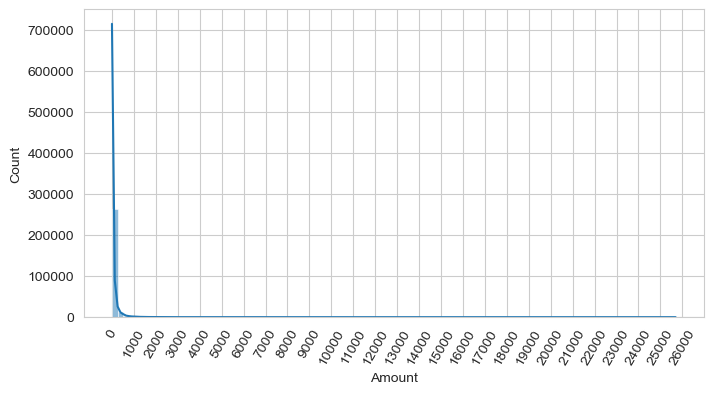

In [124]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

카드 사용 금액이 1000불 이하 데이터가 대부분이며 26000불까지 드물지만 사용한 경우가 존재하여 꼬리가 긴 형태의 분포 곡선을 가진다.  
Amount를 표준 정규 분포 형태로 변환하여 로지스틱 회귀의 예측 성능을 측정해보겠다.  
이를 위해 get_processed_df()를 sklearn의 standardScaler클래스를 이용해 Amount를 정규 분포 형태로 변환한다.